In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


In [3]:
# get the data
train_data = pd.read_csv('data/train.csv', low_memory=False)
test_data = pd.read_csv('data/test.csv', low_memory=False)

In [4]:
# target column
target = 'CLASSI_FIN'

In [5]:
# looking at the target variable
train_data[target].value_counts()

5    867570
4    380410
2     31437
1     15628
3      5935
Name: CLASSI_FIN, dtype: int64

<AxesSubplot: >

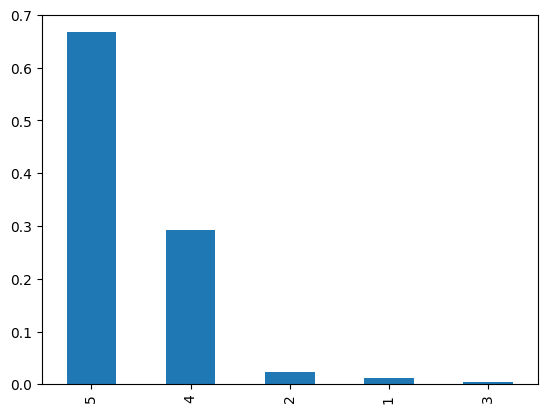

In [6]:
# plotting the target variable distribution
train_data[target].value_counts(normalize=True).plot(kind='bar')

Já podemos ver que é um problema multiclasse, onde nós temos 5 categorias onde a classe 3 é a classe mais desbalanceada. Olhando na documentação, temos:

- 1: SRAG por influenza
- 2: SRAG por outro vírus respiratório
- 3: SRAG por outro agente etiológico
- 4: SRAG não especificado
- 5: SRAG por covid-19

SRAG = Síndrome respiratória aguda grave

A fim de trazer um baseline para esse case, vamos da uma olhadinha nos missing values, e trazer uma solução simples para eles.

In [7]:
train_data.columns

Index(['SEM_NOT', 'SEM_PRI', 'SG_UF_NOT', 'ID_REGIONA', 'CO_REGIONA',
       'ID_MUNICIP', 'CO_MUN_NOT', 'CS_SEXO', 'NU_IDADE_N', 'TP_IDADE',
       'COD_IDADE', 'CS_GESTANT', 'CS_RACA', 'CS_ESCOL_N', 'SG_UF', 'CS_ZONA',
       'SURTO_SG', 'NOSOCOMIAL', 'AVE_SUINO', 'FEBRE', 'TOSSE', 'GARGANTA',
       'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'OUTRO_SIN',
       'OUTRO_DES', 'PUERPERA', 'FATOR_RISC', 'CARDIOPATI', 'HEMATOLOGI',
       'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI',
       'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OBES_IMC', 'OUT_MORBI',
       'MORB_DESC', 'VACINA', 'MAE_VAC', 'M_AMAMENTA', 'ANTIVIRAL',
       'TP_ANTIVIR', 'HOSPITAL', 'UTI', 'SUPORT_VEN', 'RAIOX_RES', 'RAIOX_OUT',
       'AMOSTRA', 'TP_AMOSTRA', 'OUT_AMOST', 'CLASSI_FIN', 'HISTO_VGM',
       'PAC_COCBO', 'PAC_DSCBO', 'OUT_ANIM', 'DOR_ABD', 'FADIGA', 'PERD_OLFT',
       'PERD_PALA', 'TOMO_RES', 'TOMO_OUT', 'VACINA_COV', 'DOSE_1_COV',
       'DOSE_2_COV', 'DOSE_REF

In [8]:
# looking at the missing values
train_data.isnull().sum().reset_index().sort_values(by=0, ascending=False).head(60)

,index,0
62,OUT_ANIM,1299816
42,OBES_IMC,1286880
47,M_AMAMENTA,1285578
46,MAE_VAC,1282681
60,PAC_COCBO,1272026
61,PAC_DSCBO,1272026
49,TP_ANTIVIR,1268247
68,TOMO_OUT,1263169
54,RAIOX_OUT,1254971
16,SURTO_SG,1222198


Vamos visualizar a relação de missings entre as variáveis e o target.

In [ ]:
# plotting missing values distribution
def plot_missing_values_dist_per_var(df, target, var):
    df = train_data[[var, target]].value_counts(dropna=False).reset_index()
    df = df.replace({var: {np.nan: "Missing"}})
    df = df.rename(columns={0: "count"})
    df_missing = df[df[var] == "Missing"].plot(kind="bar", x=target, y="count", color="blue", title=var)

# for column in train_data.columns:
#     if column != target:
#         try:
#             plot_missing_values_dist_per_var(train_data, target, column)
#         except:
#             continue

Basicamente, a opção de dropar missing values não é viável, pois a maioria das variáveis tem missing values. Então corremos o risco de basicamente excluir a base ou categorias inteiras do nosso target.

Interessante, nós temos missing values em 57 colunas das 76 que temos no dataset. Para dar uma simplificada, vamos admitir aqui em um primeiro momento que as informações pessoais do paciente como dados socio-regionais não são importantes para o nosso target. 

# Trabalho de corno

In [25]:
full_columns = train_data.columns
drooped_columns = set(full_columns) - set(columns_to_keep)
print(list(drooped_columns))

['PAC_COCBO', 'AMOSTRA', 'CO_REGIONA', 'CS_ZONA', 'HISTO_VGM', 'SG_UF', 'SEM_NOT', 'OUT_AMOST', 'SURTO_SG', 'CO_MUN_NOT', 'SEM_PRI', 'ID_MUNICIP', 'PAC_DSCBO', 'OUT_ANIM', 'ID_REGIONA', 'COD_IDADE', 'CS_ESCOL_N', 'TP_IDADE', 'M_AMAMENTA', 'TP_AMOSTRA', 'CS_RACA', 'SG_UF_NOT']


In [11]:
train_data_dropped_columns = train_data[columns_to_keep]
train_data_dropped_columns.head()

,CS_SEXO,NU_IDADE_N,CS_GESTANT,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,...,PERD_PALA,TOMO_RES,TOMO_OUT,VACINA_COV,DOSE_1_COV,DOSE_2_COV,DOSE_REF,FNT_IN_COV,DELTA_UTI,ID
0,M,73,6,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,0,0,0,1.0,-1,87360a9a-5516-4b0c-9c76-faceb759e97b
1,M,27,6,NaN,NaN,1.0,1.0,1.0,2.0,2.0,...,2.0,NaN,NaN,9.0,0,0,0,1.0,-1,e5532e89-f7e8-4239-991b-16cf3c3a5be6
2,F,2,6,2.0,2.0,1.0,1.0,2.0,2.0,1.0,...,2.0,6.0,NaN,1.0,1,1,0,2.0,-1,dbaa33c2-d374-48d7-a0f3-f0775550b1a4
3,F,71,5,2.0,2.0,2.0,2.0,2.0,1.0,1.0,...,2.0,6.0,NaN,1.0,1,1,0,2.0,-1,ecbf8128-42a7-4668-be28-905b6168578d
4,F,91,5,2.0,2.0,2.0,1.0,2.0,2.0,2.0,...,2.0,NaN,NaN,2.0,0,0,0,1.0,-1,4b74f720-bd35-42b0-8590-127985c79653


In [12]:
target_column = train_data_dropped_columns[target]
ID_column = train_data_dropped_columns["ID"]
train_data_dropped_target = train_data_dropped_columns.drop(columns=[target, "ID"])
train_random_sampled = train_data_dropped_target.sample(axis=1, frac=1, random_state=42)

In [13]:
for var in train_random_sampled.columns:
    display(train_random_sampled[var].value_counts(dropna=False).reset_index())

,index,SIND_DOWN
0,NaN,854141
1,2.0,433504
2,9.0,8856
3,1.0,4479


,index,FADIGA
0,2.0,587107
1,NaN,389988
2,1.0,299101
3,9.0,24784


,index,DOSE_1_COV
0,0,917531
1,1,383449


,index,VOMITO
0,2.0,739371
1,NaN,422753
2,1.0,116060
3,9.0,22796


,index,PERD_PALA
0,2.0,745223
1,NaN,434644
2,1.0,87165
3,9.0,33948


,index,FEBRE
0,1.0,668205
1,2.0,386025
2,NaN,231370
3,9.0,15380


,index,CARDIOPATI
0,NaN,720016
1,1.0,355651
2,2.0,219595
3,9.0,5718


,index,FNT_IN_COV
0,1.0,640448
1,2.0,411556
2,NaN,248976


,index,NOSOCOMIAL
0,2.0,989437
1,NaN,201505
2,9.0,83760
3,1.0,26278


,index,MAE_VAC
0,NaN,1282681
1,9.0,10445
2,2.0,6020
3,1.0,1834


,index,OUTRO_SIN
0,2.0,475519
1,1.0,403024
2,NaN,395283
3,9.0,27154


,index,DISPNEIA
0,1.0,873891
1,2.0,239892
2,NaN,176050
3,9.0,11147


,index,RENAL
0,NaN,844404
1,2.0,407671
2,1.0,39747
3,9.0,9158


,index,TOSSE
0,1.0,873921
1,2.0,242787
2,NaN,172085
3,9.0,12187


,index,TP_ANTIVIR
0,NaN,1268247
1,1.0,27819
2,3.0,4592
3,2.0,322


,index,AVE_SUINO
0,2.0,879296
1,NaN,219917
2,9.0,189228
3,1.0,11375
4,3.0,1164


,index,SUPORT_VEN
0,2.0,645455
1,3.0,256721
2,1.0,196092
3,NaN,164962
4,9.0,37750


,index,PNEUMOPATI
0,NaN,839798
1,2.0,401972
2,1.0,49847
3,9.0,9363


,index,TOMO_RES
0,NaN,455610
1,1.0,365356
2,6.0,295660
3,9.0,74398
4,5.0,45323
5,2.0,33853
6,3.0,24856
7,4.0,5924


,index,ANTIVIRAL
0,2.0,855810
1,NaN,224350
2,9.0,181723
3,1.0,39097


,index,DOSE_REF
0,0,1196008
1,1,104972


,index,PUERPERA
0,NaN,853453
1,2.0,434179
2,9.0,9006
3,1.0,4342


,index,DESC_RESP
0,1.0,695894
1,2.0,329467
2,NaN,261255
3,9.0,14364


,index,FATOR_RISC
0,1,735030
1,2,565950


,index,MORB_DESC
0,NaN,983550
1,HAS,84636
2,HIPERTENSAO,7278
3,HIPOTIREOIDISMO,6578
4,TABAGISTA,5213
...,...,...
78113,"TX RENAL 2018, EX-TABAGISTA",1
78114,"ACAMADO , HAS",1
78115,HPB/NEOPLASIA C/ METASTASE,1
78116,DOENCA FALSIFORME,1


,index,UTI
0,2.0,735226
1,1.0,379486
2,NaN,162527
3,9.0,23741


,index,IMUNODEPRE
0,NaN,846942
1,2.0,412174
2,1.0,32183
3,9.0,9681


,index,DIARREIA
0,2.0,722603
1,NaN,414223
2,1.0,141925
3,9.0,22229


,index,CS_SEXO
0,M,697225
1,F,603567
2,I,188


,index,VACINA_COV
0,2.0,459504
1,1.0,420822
2,NaN,249379
3,9.0,171275


,index,OBESIDADE
0,NaN,828458
1,2.0,371979
2,1.0,89588
3,9.0,10955


,index,VACINA
0,9.0,419227
1,2.0,390271
2,NaN,384795
3,1.0,106687


,index,RAIOX_OUT
0,NaN,1254971
1,SEM LAUDO,3165
2,OPACIDADES,2468
3,OPACIDADE,2293
4,TOMOGRAFIA,1477
...,...,...
11257,INFILTRADO PARACARDIACO DIR,1
11258,CONG.PULMONAR,1
11259,AUMENTO INDICE CARDIOPATICO,1
11260,PINCAMENTO DISC EM HEMITORAX,1


,index,OUT_MORBI
0,NaN,749210
1,1.0,321050
2,2.0,223596
3,9.0,7124


,index,TOMO_OUT
0,NaN,1263169
1,VIDRO FOSCO,2563
2,DERRAME PLEURAL,1607
3,SOLICITADO,1457
4,SEM LAUDO,1188
...,...,...
10367,IRA REALIZAR HOJE AS 20HS,1
10368,CONSOLIDACOES ASSOCIADAS A OPA,1
10369,DISCRETO INFILTRADO,1
10370,OPACIDADES CONSOLIDATIVAS COMP,1


,index,NU_IDADE_N
0,1,35446
1,2,27713
2,59,22782
3,57,22662
4,58,22466
...,...,...
122,-2,1
123,124,1
124,119,1
125,150,1


,index,ASMA
0,NaN,841920
1,2.0,405678
2,1.0,44553
3,9.0,8829


,index,CS_GESTANT
0,6,843853
1,5,391911
2,9,51502
3,3,8168
4,2,3297
5,1,1398
6,4,671
7,0,180


,index,DOR_ABD
0,2.0,755558
1,NaN,439039
2,1.0,78639
3,9.0,27744


,index,HOSPITAL
0,1.0,1249087
1,NaN,26483
2,2.0,23375
3,9.0,2035


,index,NEUROLOGIC
0,NaN,839191
1,2.0,400299
2,1.0,52237
3,9.0,9253


,index,DOSE_2_COV
0,0,997827
1,1,303153


,index,SATURACAO
0,1.0,788268
1,2.0,274740
2,NaN,223622
3,9.0,14350


,index,DIABETES
0,NaN,762133
1,2.0,292767
2,1.0,239499
3,9.0,6581


,index,HEMATOLOGI
0,NaN,852697
1,2.0,429270
2,9.0,9817
3,1.0,9196


,index,DELTA_UTI
0,-1,1300980


,index,HEPATICA
0,NaN,854292
1,2.0,427244
2,9.0,9768
3,1.0,9676


,index,GARGANTA
0,2.0,679186
1,NaN,396565
2,1.0,199834
3,9.0,25395


,index,PERD_OLFT
0,2.0,747784
1,NaN,434124
2,1.0,85759
3,9.0,33313


,index,OUTRO_DES
0,NaN,904480
1,CEFALEIA,33496
2,CORIZA,31796
3,MIALGIA,29043
4,ASTENIA,10410
...,...,...
85053,"MAL ESTAR INAPETENCIA,DOR MMII",1
85054,DOR PARA URINAR,1
85055,"CRISE CONVULSIVA,TORPOR",1
85056,"CEFALEIA,DOR NA LOMBAR",1


,index,OBES_IMC
0,NaN,1286880
1,30,1655
2,0,1393
3,40,897
4,35,634
...,...,...
469,"53,6",1
470,"54,5",1
471,425,1
472,72,1


,index,RAIOX_RES
0,NaN,532081
1,6.0,350319
2,2.0,155519
3,9.0,120290
4,5.0,59567
5,1.0,40901
6,3.0,22133
7,4.0,20170


In [14]:
train_random_sampled.drop(["TOMO_OUT", "RAIOX_OUT", "OUT_MORBI", "MORB_DESC", "OUTRO_DES", "OBES_IMC"], axis=1, inplace=True)

In [15]:
# replacing missing values with a 9
train_random_sampled = train_random_sampled.fillna(9)
# encoding CS_SEXO categorical variables to numeric
train_random_sampled["CS_SEXO"] = train_random_sampled["CS_SEXO"].replace({"M": 0, "F": 1, "I": -1})
train_random_sampled.isnull().sum().reset_index()

,index,0
0,SIND_DOWN,0
1,FADIGA,0
2,DOSE_1_COV,0
3,VOMITO,0
4,PERD_PALA,0
5,FEBRE,0
6,CARDIOPATI,0
7,FNT_IN_COV,0
8,NOSOCOMIAL,0
9,MAE_VAC,0


# Modeling

In [19]:
# catboost hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from catboost import CatBoostClassifier
# create test and train datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train_random_sampled, target_column, test_size=0.2, random_state=42, stratify=target_column
)

clf = CatBoostClassifier(
    iterations=1000,
    verbose=5,
    random_state=42,
)

grid = {
    "learning_rate": [0.01, 0.1, 0.5, 1],
    "depth": [4, 6, 10],
    "l2_leaf_reg": [1, 4, 9],
    "border_count": [32, 5, 10, 20, 50, 100, 200],
    # "scale_pos_weight": [1, 2, 3],
}

grid_search_result = clf.randomized_search(grid, X=X_train, y=y_train, plot=True)

# clf.get_best_score()

# clf.get_best_params()

# clf.get_best_iteration()

# clf.get_best_model()


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.4009383	test: 1.4012909	best: 1.4012909 (0)	total: 134ms	remaining: 2m 13s
5:	learn: 0.9520332	test: 0.9532972	best: 0.9532972 (5)	total: 552ms	remaining: 1m 31s
10:	learn: 0.7801805	test: 0.7822446	best: 0.7822446 (10)	total: 966ms	remaining: 1m 26s
15:	learn: 0.6959720	test: 0.6986502	best: 0.6986502 (15)	total: 1.37s	remaining: 1m 24s
20:	learn: 0.6511469	test: 0.6543522	best: 0.6543522 (20)	total: 1.79s	remaining: 1m 23s
25:	learn: 0.6271732	test: 0.6307835	best: 0.6307835 (25)	total: 2.21s	remaining: 1m 22s
30:	learn: 0.6127006	test: 0.6166035	best: 0.6166035 (30)	total: 2.62s	remaining: 1m 21s
35:	learn: 0.6037843	test: 0.6078995	best: 0.6078995 (35)	total: 3.03s	remaining: 1m 21s
40:	learn: 0.5981704	test: 0.6023825	best: 0.6023825 (40)	total: 3.41s	remaining: 1m 19s
45:	learn: 0.5942208	test: 0.5985439	best: 0.5985439 (45)	total: 3.81s	remaining: 1m 18s
50:	learn: 0.5913075	test: 0.5957704	best: 0.5957704 (50)	total: 4.2s	remaining: 1m 18s
55:	learn: 0.5891217	test:

In [22]:
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)

In [85]:


# training a model
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from catboost import CatBoostClassifier

# clf = CatBoostClassifier(
#     iterations=1000,
#     verbose=5,
#     random_state=42,
# )

# rf = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight="balanced", n_jobs=10)
hg = HistGradientBoostingClassifier(random_state=42, max_iter=1000, learning_rate=0.1, max_depth=25, class_weight="balanced")
hg.fit(X_train, y_train)

# evaluating the model
from sklearn.metrics import classification_report

y_pred = hg.predict(X_test)


In [23]:
print(classification_report(y_test, y_pred, digits=4, target_names=["1", "2", "3", "4", "5"]))

              precision    recall  f1-score   support

           1     0.5913    0.0995    0.1703      3126
           2     0.5146    0.0617    0.1102      6287
           3     0.5000    0.0143    0.0278      1187
           4     0.6393    0.5265    0.5774     76082
           5     0.8069    0.9125    0.8564    173514

    accuracy                         0.7652    260196
   macro avg     0.6104    0.3229    0.3484    260196
weighted avg     0.7468    0.7652    0.7448    260196



In [64]:
def get_classification_report(y_test, y_pred):
    report = classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
    return df_classification_report

get_classification_report(y_test, y_pred)

,precision,recall,f1-score,support
5,0.798739,0.894216,0.843785,173514.000000
accuracy,0.742529,0.742529,0.742529,0.742529
weighted avg,0.721205,0.742529,0.726857,260196.000000
4,0.604731,0.477485,0.533627,76082.000000
macro avg,0.433140,0.344738,0.367410,260196.000000
2,0.294908,0.216478,0.249679,6287.000000
1,0.332272,0.100128,0.153884,3126.000000
3,0.135048,0.035383,0.056075,1187.000000


In [38]:
columns_to_keep_test = [
    "CS_SEXO",
    "NU_IDADE_N",
    "CS_GESTANT",
    "NOSOCOMIAL",
    "AVE_SUINO",
    "FEBRE",
    "TOSSE",
    "GARGANTA",
    "DISPNEIA",
    "DESC_RESP",
    "SATURACAO",
    "DIARREIA",
    "VOMITO",
    "OUTRO_SIN",
    "OUTRO_DES",
    "PUERPERA",
    "FATOR_RISC",
    "CARDIOPATI",
    "HEMATOLOGI",
    "SIND_DOWN",
    "HEPATICA",
    "ASMA",
    "DIABETES",
    "NEUROLOGIC",
    "PNEUMOPATI",
    "IMUNODEPRE",
    "RENAL",
    "OBESIDADE",
    "OBES_IMC",
    "OUT_MORBI",
    "MORB_DESC",
    "VACINA",
    "MAE_VAC",
    "ANTIVIRAL",
    "TP_ANTIVIR",
    "HOSPITAL",
    "UTI",
    "SUPORT_VEN",
    "RAIOX_RES",
    "RAIOX_OUT",
    "DOR_ABD",
    "FADIGA",
    "PERD_OLFT",
    "PERD_PALA",
    "TOMO_RES",
    "TOMO_OUT",
    "VACINA_COV",
    "DOSE_1_COV",
    "DOSE_2_COV",
    "DOSE_REF",
    "FNT_IN_COV",
    "DELTA_UTI",
    "ID",
]


In [41]:
# Creating the submission file
test_data_dropped_columns = test_data[columns_to_keep_test]
test_id_column = test_data_dropped_columns["ID"]
test_data_dropped_ID = test_data_dropped_columns.drop(columns=["ID"])
test_random_sampled = test_data_dropped_ID.sample(axis=1, frac=0.4, random_state=42)
test_random_sampled = test_random_sampled.fillna(9)
test_random_sampled

,SIND_DOWN,FADIGA,DOSE_1_COV,VOMITO,PERD_PALA,FEBRE,CARDIOPATI,FNT_IN_COV,NOSOCOMIAL,MAE_VAC,...,DISPNEIA,RENAL,TOSSE,TP_ANTIVIR,AVE_SUINO,SUPORT_VEN,PNEUMOPATI,TOMO_RES,ANTIVIRAL,DOSE_REF
0,9.0,2.0,0,2.0,2.0,1.0,9.0,1.0,2.0,9.0,...,2.0,9.0,1.0,9.0,2.0,3.0,9.0,6.0,2.0,0
1,9.0,9.0,0,9.0,9.0,9.0,1.0,2.0,2.0,9.0,...,9.0,9.0,9.0,9.0,2.0,2.0,9.0,9.0,2.0,0
2,9.0,1.0,0,9.0,9.0,1.0,9.0,2.0,9.0,9.0,...,1.0,9.0,1.0,9.0,9.0,9.0,9.0,9.0,2.0,1
3,9.0,2.0,0,2.0,2.0,2.0,9.0,1.0,2.0,9.0,...,1.0,9.0,1.0,9.0,2.0,3.0,9.0,4.0,2.0,0
4,9.0,9.0,0,9.0,9.0,9.0,1.0,1.0,2.0,9.0,...,1.0,9.0,9.0,9.0,2.0,2.0,9.0,9.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867316,9.0,9.0,1,9.0,9.0,9.0,9.0,2.0,9.0,9.0,...,9.0,9.0,9.0,9.0,9.0,3.0,9.0,9.0,9.0,1
867317,9.0,9.0,0,9.0,9.0,1.0,9.0,2.0,2.0,9.0,...,9.0,9.0,1.0,9.0,2.0,2.0,9.0,9.0,2.0,0
867318,9.0,9.0,0,2.0,9.0,2.0,9.0,9.0,2.0,9.0,...,2.0,9.0,2.0,9.0,2.0,2.0,9.0,9.0,9.0,0
867319,9.0,1.0,0,9.0,9.0,1.0,9.0,2.0,2.0,9.0,...,1.0,9.0,1.0,9.0,2.0,2.0,9.0,9.0,2.0,0


In [42]:
preds = rf.predict(test_random_sampled)
submission_file = pd.DataFrame({"ID": test_id_column, "CLASSI_FIN": preds})
submission_file

,ID,CLASSI_FIN
0,c42342a4-cfca-497f-8ee6-a6c76ed4bc67,4
1,6c86b555-8bf2-4306-8f2e-db809a98e3c3,4
2,0ac9582e-2683-474b-8316-5e9c0ea6edd5,4
3,7bc6de6f-041c-4866-8778-7542c230a498,4
4,8eefb2e4-626e-4f40-9b93-5146906fe07b,5
...,...,...
867316,981cdc34-b821-4695-aa7d-b60a3d8788e4,5
867317,d48cb14d-d10c-4e98-9075-5ab77b06e76a,4
867318,f038c8c5-1f86-4b04-98d2-9cd72e12eac5,5
867319,edcdd9a6-10a4-4681-8c2c-b2a8fb73be05,4


In [ ]:
submission_file.to_csv("data/submission_first_pipeline.csv", index=False)

- Analisar Tipos de campos e Presença de valores missing: Interno, Obrigatório, Essencial, Opcional
 